In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import math
from matplotlib.path import Path
from PIL import Image
import os
import glob
import pickle
from scipy.spatial import Delaunay

In [5]:
img1 = plt.imread('images/img1-1.png')
img2 = plt.imread('images/img2.png')

with open('data/triangulation_morph.json', 'r') as f:
    data = json.load(f)

midway_points = np.array(data['midway_points'])
simplices = np.array(data['simplices'])

with open('data/correspondance.json', 'r') as f:
    correspondance_data = json.load(f)

points1 = np.array(correspondance_data["im1Points"])
points2 = np.array(correspondance_data["im2Points"])

In [6]:
def computeAffine(one, two, triangle):
    one = np.array([one[triangle[0]], one[triangle[1]], one[triangle[2]]])
    two = np.array([two[triangle[0]], two[triangle[1]], two[triangle[2]]])
    affine_2x3 = cv2.getAffineTransform(np.float32(one), np.float32(two))
    affine_3x3 = np.vstack([affine_2x3, [0, 0, 1]]) 
    return np.linalg.inv(affine_3x3)[:2, :]

def inversewarp(img, affines, triPoints, avg_shape, triPaths):
    res = np.zeros(img.shape)
    labels = {}
    points = [(x, y) for x in range(res.shape[1]) for y in range(res.shape[0])]

    #find bounding box to see if triangle is inside to warp only pixels in triangle
    for j, t in enumerate(triPaths):
        minx, miny = np.floor(np.min(t.vertices, axis=0)).astype(int)
        maxx, maxy = np.ceil(np.max(t.vertices, axis=0)).astype(int)
        box = np.array([[x, y] for x in range(minx, maxx + 1) for y in range(miny, maxy + 1)])
        locs = t.contains_points(box)
        for i, is_inside in enumerate(locs):
            if is_inside:
                labels[tuple(box[i])] = j 
    #apply the affine transformation per triangle
    for pt in points:
        if pt in labels:
            Tinv = affines[labels[pt]]
            ndot = np.dot(Tinv, [pt[0], pt[1], 1])
            npoint = np.clip(ndot[:2], [0, 0], [img.shape[1] - 1, img.shape[0] - 1]).astype(int)
            res[pt[1], pt[0], :] = img[npoint[1], npoint[0], :]
    
    return res
    
def mid(img, img_pts, avg_shape, triangle):
    tpoints = np.array([[avg_shape[x[0]],avg_shape[x[1]],avg_shape[x[2]]] for x in triangle])
    affines = {}
    triPaths = []
    
    for x in range(0,triangle.shape[0]):
        A = computeAffine(img_pts, avg_shape, triangle[x])
        tpts = tpoints[x]
        triPaths.append(Path(tpts))
        affines[x] = A
        
    res = inversewarp(img, affines, triangle, avg_shape, triPaths)
    return res

In [7]:
nimg1 = mid(img1, points1, midway_points, simplices)
nimg2 = mid(img2, points2, midway_points, simplices)

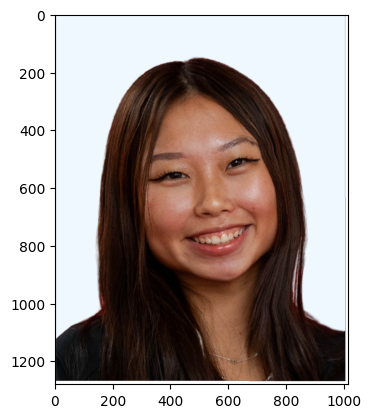

In [25]:
plt.imsave("merge1.png", nimg1)
plt.imshow(nimg1)

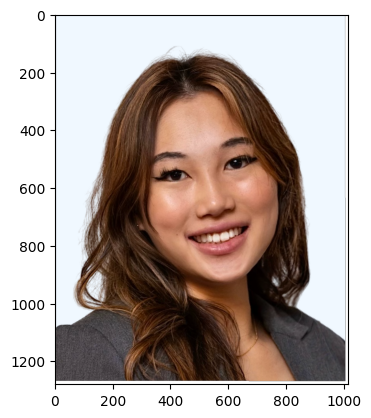

In [104]:
plt.imsave("merge2.png", nimg2)
plt.imshow(nimg2)

In [ ]:
img_new = nimg1+0.5*(nimg2-nimg1)
plt.imsave("merge_final.png", img_new)
plt.imshow(img_new)

In [ ]:
def morph(im1, im2, im1_pts, im2_pts, tri, frac):
    im1 = im1*255
    im2 = im2*255
    avg = im1_pts + frac * (im2_pts - im1_pts)
    img1 = mid(im1, im1_pts, avg, tri)
    img2 = mid(im2, im2_pts, avg, tri)
    morphed_image = img1 + frac * (img2 - img1)
    morphed_image = np.clip(morphed_image, 0, 255).astype(np.uint8)
    return morphed_image

In [256]:
for step in range(0,46):
    frac = (1./45.)*step
    morphed_im = morph(img1, img2, points1, points2, simplices, frac)
    img = Image.fromarray(morphed_im).convert('RGB')
    filename = f"out/{step}.jpg"
    img.save(filename)


In [268]:
images = [f"{i}.jpg" for i in range(46)] 

frame = cv2.imread(os.path.join("out", images[0]))
height, width, layers = frame.shape

mp4 = cv2.VideoWriter_fourcc(*'mp4v')  
video = cv2.VideoWriter("combined_video.mp4", mp4, 15, (width, height))

for image in images:
    img_path = os.path.join("out", image)
    frame = cv2.imread(img_path)
    
    if frame is None:
        print(f"Error reading {img_path}")
        continue
    
    video.write(frame)

video.release()

In [58]:
def load_pts_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    start_idx = lines.index('{\n') + 1
    end_idx = lines.index('}\n')
    
    points = []

    for line in lines[start_idx:end_idx]:
        x, y = map(float, line.strip().split())
        points.append([x, y])
    
    return np.array(points)

In [308]:
img_dir = 'mean_face/brazil'
pt_dir = 'mean_face/correspondance'
img_files = glob.glob(os.path.join(img_dir, '*b.jpg'))
face_shapes = {}

for img_path in img_files:
    base_name = os.path.basename(img_path).replace('.jpg', '')
    pt_file_path = os.path.join(pt_dir, f'{base_name}.pts')
    
    if os.path.exists(pt_file_path):
        points_np = load_pts_file(pt_file_path)
        img = cv2.imread(img_path)
        height, width = img.shape[:2]
        corners = np.array([[0, 0],                # Top-left
                            [width - 1, 0],        # Top-right
                            [0, height - 1],       # Bottom-left
                            [width - 1, height - 1]])  # Bottom-right
        points_with_corners = np.vstack((points_np, corners))
        face_shapes[base_name] = points_with_corners
face_shapes_np = np.array(list(face_shapes.values()))
average_face_shape = np.mean(face_shapes_np, axis=0)
np.save('average_face_shape_2.npy', average_face_shape)
average_face_shape_tri = Delaunay(average_face_shape)

In [309]:
allfaces = []
for i, img_path in enumerate(img_files):
    base_name = os.path.basename(img_path).replace('.jpg', '')
    img = cv2.imread(img_path)
    img_pts = face_shapes_np[i]
    img_morphed = mid(img, img_pts, average_face_shape, avg_triangles.simplices)
    allfaces.append(img_morphed)

    # Save the morphed result
    output_path = os.path.join('mean_face/output', f'{base_name}_morphed_2.jpg')
    cv2.imwrite(output_path, img_morphed)

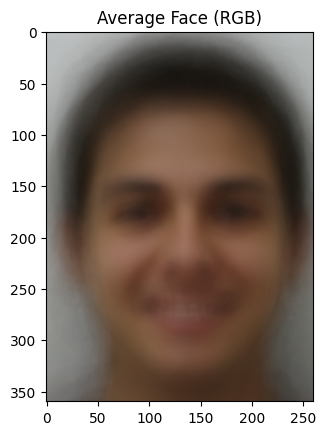

In [330]:
allfaces_np = np.array(allfaces, dtype=np.float32)
average_face_image = np.mean(allfaces_np, axis=0)
average_face_image = np.clip(average_face_image, 0, 255).astype(np.uint8)
average_face_image_rgb = cv2.cvtColor(average_face_image, cv2.COLOR_BGR2RGB)
plt.imshow(average_face_image_rgb)
plt.title("Average Face (RGB)")
plt.imsave("average_brazilian_face_rgb_2.jpg", average_face_image_rgb)
plt.show()

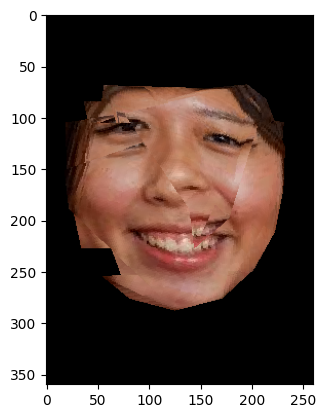

In [331]:
resized_img = plt.imread('me_resized.jpg')
resized_img = resized_img.astype(np.float32) / 255.0
with open('correspondence_points_2.json', 'r') as f:
    correspondance_data = json.load(f)
resized_points = np.array(correspondance_data)
img_morphed = mid(resized_img, resized_points, average_face_shape, average_face_shape_tri.simplices)
plt.imsave("images/me_danish.png", img_morphed)
plt.imshow(img_morphed)

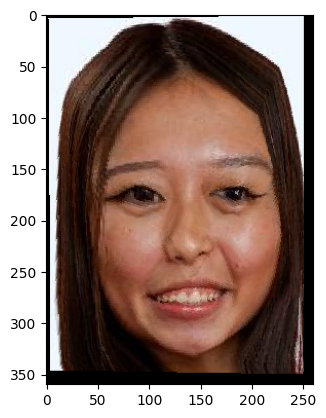

In [295]:
with open('correspondance_points_3.json', 'r') as f:
    correspondance_data = json.load(f)

points1 = np.array(correspondance_data["im1Points"])
points2 = np.array(correspondance_data["im2Points"])
tri = Delaunay(points2)

img_morphed = mid(resized_img, points1, points2, tri.simplices)
plt.imsave("images/me_danish_2.png", img_morphed)
plt.imshow(img_morphed)

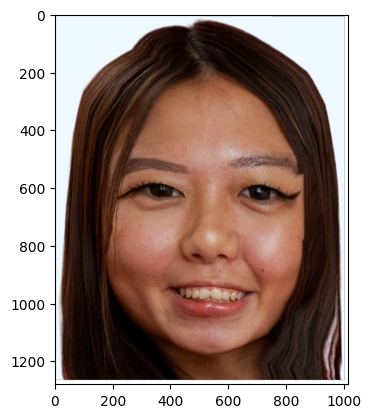

In [332]:
resized_img = plt.imread('average_brazilian_face_resized.jpg')
resized_img = resized_img.astype(np.float32) / 255.0
with open('correspondance.json', 'r') as f:
    correspondance_data = json.load(f)
points1 = np.array(correspondance_data["im1Points"])
points2 = np.array(correspondance_data["im2Points"])
average_face_shape_tri = Delaunay(points2)
img_morphed = mid(img1, points1, points2, average_face_shape_tri.simplices)
plt.imsave("images/me_danish_3.png", img_morphed)
plt.imshow(img_morphed)

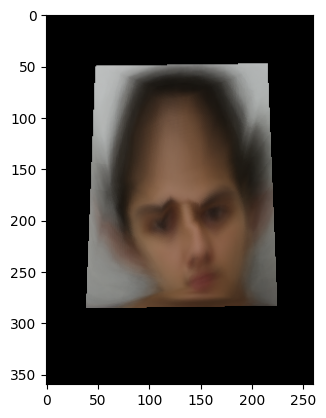

In [321]:
average_face_image_rgb_normalized = average_face_image_rgb / 255.0
resized_points_tri = Delaunay(resized_points)
img_morphed = mid(average_face_image_rgb_normalized, average_face_shape, resized_points, resized_points_tri.simplices)
img_morphed_normalized = np.clip(img_morphed, 0, 1)
plt.imsave("images/danish_me.png", (img_morphed_normalized * 255).astype(np.uint8))

# Display the result
plt.imshow(img_morphed_normalized)
plt.show()

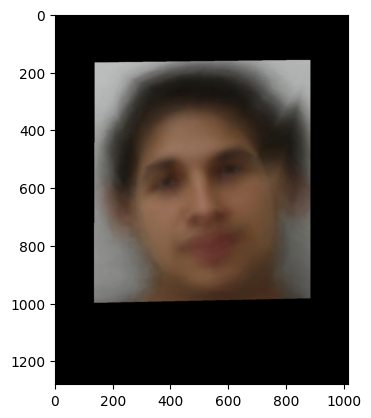

In [322]:
average_face_image_rgb_normalized = average_face_image_rgb / 255.0
resized_points_tri = Delaunay(points1)
img_morphed = mid(resized_img, points2, points1, resized_points_tri.simplices)
img_morphed_normalized = np.clip(img_morphed, 0, 1)
plt.imsave("images/danish_me_2.png", (img_morphed_normalized * 255).astype(np.uint8))

# Display the result
plt.imshow(img_morphed_normalized)
plt.show()

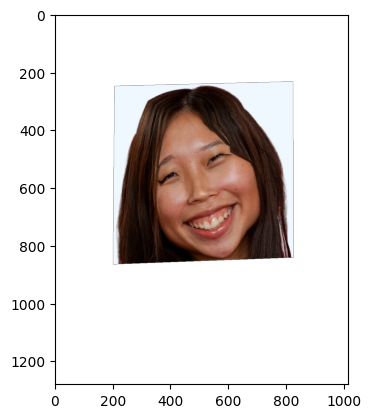

In [335]:
caricature = points1 + 0.5 * (points1 - points2)
average_face_shape_tri = Delaunay(points2)
caricature_face = mid(img1, points1, caricature, average_face_shape_tri.simplices)
plt.figure()
plt.imshow(caricature_face)
plt.imsave("caricature1-2.png", caricature_face)
plt.show()

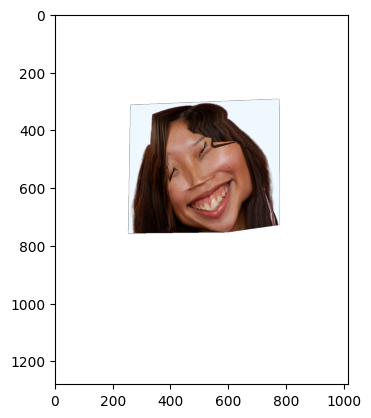

In [334]:
caricature = points1 + 0.9 * (points1 - points2)
average_face_shape_tri = Delaunay(points2)
caricature_face = mid(img1, points1, caricature, average_face_shape_tri.simplices)
plt.figure()
plt.imshow(caricature_face)
plt.imsave("caricature1-2.png", caricature_face)
plt.show()

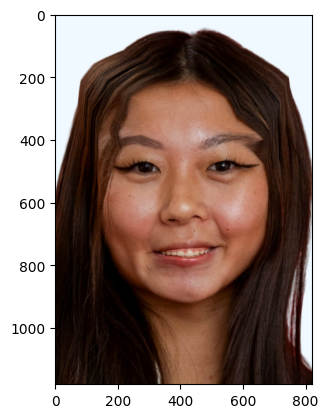

In [23]:
img1 = cv2.imread('bw/img1_resized.jpg')
img2 = cv2.imread('bw/img2_resized.jpg')

with open('bw/correspondance.json', 'r') as f:
    correspondance_data = json.load(f)

points1 = np.array(correspondance_data["im1Points"])
points2 = np.array(correspondance_data["im2Points"])

height, width = nimg1.shape[:2]
corners = np.array([[0, 0],                # Top-left
                    [width - 1, 0],        # Top-right
                    [0, height - 1],       # Bottom-left
                    [width - 1, height - 1]])  # Bottom-right

points1_with_corners = np.vstack((points1, corners))
points2_with_corners = np.vstack((points2, corners))

midway_points = (points1_with_corners + points2_with_corners) / 2
midway_tri = Delaunay(midway_points)

points2_tri = Delaunay(points2_with_corners)

nimg1 = mid(img1, points1_with_corners, points2_with_corners, points2_tri.simplices)

nimg1_normalized = cv2.normalize(nimg1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
rgb = cv2.cvtColor(nimg1_normalized, cv2.COLOR_BGR2RGB)

plt.imshow(rgb , cmap='gray')
plt.imsave("morph.jpg", rgb , cmap='gray')
plt.show()

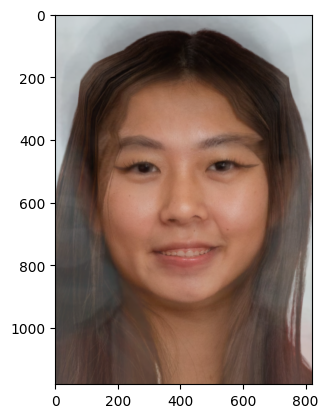

In [36]:
nimg2 = mid(img2, points2_with_corners, midway_points, midway_tri.simplices)

nimg2_normalized = cv2.normalize(nimg2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
nimg2_rgb = cv2.cvtColor(nimg2_normalized, cv2.COLOR_BGR2RGB)

nimg2_rgb_float = nimg2_rgb.astype(np.float64)
rgb_float = rgb.astype(np.float64)

img_new = rgb_float + 0.5 * (nimg2_rgb_float - rgb_float)

img_new_clipped = np.clip(img_new, 0, 255).astype(np.uint8)

# Display and save the image
plt.imsave("male_me.png", img_new_clipped)
plt.imshow(img_new_clipped)
plt.show()

In [35]:
nimg2_rgb.dtype

dtype('uint8')